In [6]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [63]:
pip install requests pandas numpy matplotlib ta

Note: you may need to restart the kernel to use updated packages.


In [65]:
import hashlib
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta import trend, momentum, volatility
from datetime import datetime, timedelta

# =========================
# Configuration and Settings
# =========================
# List of cryptocurrencies to analyze (CoinGecko IDs)
CRYPTOCURRENCIES = ['bitcoin', 'ethereum', 'litecoin']

# Fiat currencies for exchange rates
FIAT_CURRENCIES = ['USD', 'EUR', 'JPY', 'GBP', 'AUD']

# Timeframe for historical data (Last 90 days)
DAYS = '90'  # Changed to string to align with API expectations

# Technical indicators settings
SMA_SHORT = 20  # Short-term Simple Moving Average
SMA_LONG = 50   # Long-term Simple Moving Average
RSI_PERIOD = 14
# VOLATILITY_PERIOD = 14  # Removed ATR due to lack of High/Low data

# =========================
# Utility Functions
# =========================
def get_hash(data):
    """Generates a SHA-256 hash for the given data."""
    hash_object = hashlib.sha256(data.encode())
    return hash_object.hexdigest()

def fetch_coin_gecko_data(crypto_id, vs_currency='usd', days='90'):
    """Fetches historical market data for a cryptocurrency from CoinGecko."""
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        raise Exception(f"Error fetching data from CoinGecko for {crypto_id}: {response.status_code} {response.reason}")
    data = response.json()
    
    # Inspect raw data (Optional: For debugging purposes)
    # print(f"Raw CoinGecko data for {crypto_id}: {data}")
    
    prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
    
    # Verify timestamp units by checking the first few entries
    # Convert first timestamp to datetime to check
    sample_timestamp = prices['timestamp'].iloc[0]
    sample_date = pd.to_datetime(sample_timestamp, unit='ms')
    print(f"Sample CoinGecko Timestamp: {sample_timestamp} -> Date: {sample_date}")
    
    prices['Date'] = pd.to_datetime(prices['timestamp'], unit='ms')  # Ensure unit='ms'
    prices.set_index('Date', inplace=True)
    prices['Close'] = prices['price']
    prices = prices[['Close']].sort_index()
    
    # Verify date range
    print(f"CoinGecko Data for {crypto_id}: {prices.index.min()} to {prices.index.max()}")
    
    prices['Hash'] = prices['Close'].apply(lambda x: get_hash(str(x)))
    return prices

def fetch_binance_data(symbol='BTCUSDT', interval='1d', limit=90):
    """Fetches historical klines data for a cryptocurrency from Binance."""
    url = 'https://api.binance.com/api/v3/klines'
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an HTTPError for bad responses
        data = response.json()
        
        # Inspect raw data (Optional: For debugging purposes)
        # print(f"Raw Binance data for {symbol}: {data}")
        
        klines = pd.DataFrame(data, columns=[
            'Open Time', 'Open', 'High', 'Low', 'Close', 'Volume',
            'Close Time', 'Quote Asset Volume', 'Number of Trades',
            'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore'
        ])
        
        # Verify timestamp units by checking the first few entries
        sample_close_time = klines['Close Time'].iloc[0]
        sample_date = pd.to_datetime(sample_close_time, unit='ms')
        print(f"Sample Binance Close Time: {sample_close_time} -> Date: {sample_date}")
        
        klines['Date'] = pd.to_datetime(klines['Close Time'], unit='ms')  # Ensure unit='ms'
        klines.set_index('Date', inplace=True)
        klines['Close'] = klines['Close'].astype(float)
        klines = klines[['Close']].sort_index()
        
        # Verify date range
        print(f"Binance Data for {symbol}: {klines.index.min()} to {klines.index.max()}")
        
        klines['Hash'] = klines['Close'].apply(lambda x: get_hash(str(x)))
        return klines
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from Binance for {symbol}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

def fetch_exchange_rates(base='USD'):
    """Fetches current exchange rates from multiple sources."""
    rates = {}
    # Source 1: ExchangeRate-API
    try:
        api_key = 'YOUR_EXCHANGERATE_API_KEY'  # Replace with your API key
        url = f'https://v6.exchangerate-api.com/v6/{api_key}/latest/{base}'
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            rates.update(data.get('conversion_rates', {}))
        else:
            print(f"ExchangeRate-API response status: {response.status_code}")
    except Exception as e:
        print(f"ExchangeRate-API failed: {e}")
    # Source 2: exchangerate.host
    try:
        url = f'https://api.exchangerate.host/latest?base={base}'
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            rates.update(data.get('rates', {}))
        else:
            print(f"exchangerate.host response status: {response.status_code}")
    except Exception as e:
        print(f"exchangerate.host failed: {e}")
    # Filter for desired fiat currencies
    filtered_rates = {currency: rates.get(currency) for currency in FIAT_CURRENCIES if rates.get(currency)}
    exchange_rates = pd.Series(filtered_rates, name='Exchange Rate')
    exchange_rates_hash = get_hash(exchange_rates.to_json())
    return exchange_rates, exchange_rates_hash

# =========================
# Data Fetching
# =========================
def fetch_all_crypto_data():
    """Fetches historical data from multiple sources for all cryptocurrencies."""
    crypto_data = {}
    for crypto in CRYPTOCURRENCIES:
        try:
            print(f"\nFetching data for {crypto}...")
            # Fetch from CoinGecko
            cg_data = fetch_coin_gecko_data(crypto)

            # Fetch from Binance
            symbol = crypto_symbol_mapping(crypto)
            bn_data = fetch_binance_data(symbol=symbol)

            if bn_data.empty:
                print(f"Skipping {crypto} due to empty DataFrame from Binance")
                combined = cg_data  # Use only CoinGecko data if Binance is unavailable
            else:
                # Merge data from both sources if available
                combined = pd.concat([cg_data, bn_data], axis=1, join='inner', lsuffix='_cg', rsuffix='_bn')
                combined['Close'] = combined[['Close_cg', 'Close_bn']].mean(axis=1)
                combined = combined[['Close']]

            combined['Data ID'] = combined.index.to_series().apply(lambda x: get_hash(x.strftime('%Y-%m-%d')))
            crypto_data[crypto] = combined
            print(f"Fetched data for {crypto}: {combined.shape[0]} records.")
        except Exception as e:
            print(f"Failed to fetch data for {crypto}: {e}")
    
    return crypto_data

def crypto_symbol_mapping(crypto_id):
    """Maps CoinGecko crypto IDs to Binance symbols."""
    mapping = {
        'bitcoin': 'BTCUSDT',
        'ethereum': 'ETHUSDT',
        'litecoin': 'LTCUSDT',
        # Add more mappings as needed
    }
    return mapping.get(crypto_id, 'BTCUSDT')

# =========================
# Data Analysis
# =========================
def perform_technical_analysis(df):
    """Applies technical indicators to the DataFrame using the `ta` library."""
    df['SMA_Short'] = trend.sma_indicator(close=df['Close'], window=SMA_SHORT)
    df['SMA_Long'] = trend.sma_indicator(close=df['Close'], window=SMA_LONG)
    df['RSI'] = momentum.rsi(close=df['Close'], window=RSI_PERIOD)
    
    # Corrected BollingerBands usage
    bollinger = volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()
    
    # Removed ATR due to lack of High/Low data
    # If you have High and Low data, uncomment the following lines:
    # df['ATR'] = volatility.average_true_range(high=df['High'], low=df['Low'], close=df['Close'], window=VOLATILITY_PERIOD)
    
    return df

def identify_trends(df):
    """Identifies upward and downward trends based on technical indicators."""
    df['Trend'] = 'Neutral'
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Trend'] = 'Uptrend'
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Trend'] = 'Downtrend'
    df['RSI_Status'] = 'Neutral'
    df.loc[df['RSI'] > 70, 'RSI_Status'] = 'Overbought'
    df.loc[df['RSI'] < 30, 'RSI_Status'] = 'Oversold'
    return df

# =========================
# Main Execution
# =========================
if __name__ == "__main__":
    # Fetch all cryptocurrency data
    all_crypto_data = fetch_all_crypto_data()

    # Perform technical analysis and trend identification
    for crypto, data in all_crypto_data.items():
        if data.empty:
            print(f"No data available for {crypto}. Skipping analysis.")
            continue

        # Perform technical analysis
        analyzed_data = perform_technical_analysis(data)
        
        # Identify trends
        trend_data = identify_trends(analyzed_data)

        # Print the results
        print(f"\nTechnical analysis for {crypto}:")
        print(trend_data.head())

        # Save to CSV
        csv_filename = f"{crypto}_technical_analysis.csv"
        trend_data.to_csv(csv_filename)
        print(f"Data for {crypto} saved to {csv_filename}")


Fetching data for bitcoin...
Sample CoinGecko Timestamp: 1721174400000 -> Date: 2024-07-17 00:00:00
CoinGecko Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 19:55:45
Error fetching data from Binance for BTCUSDT: 451 Client Error:  for url: https://api.binance.com/api/v3/klines?symbol=BTCUSDT&interval=1d&limit=90
Skipping bitcoin due to empty DataFrame from Binance
Fetched data for bitcoin: 91 records.

Fetching data for ethereum...
Sample CoinGecko Timestamp: 1721174400000 -> Date: 2024-07-17 00:00:00
CoinGecko Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 20:02:27
Error fetching data from Binance for ETHUSDT: 451 Client Error:  for url: https://api.binance.com/api/v3/klines?symbol=ETHUSDT&interval=1d&limit=90
Skipping ethereum due to empty DataFrame from Binance
Fetched data for ethereum: 91 records.

Fetching data for litecoin...
Sample CoinGecko Timestamp: 1721174400000 -> Date: 2024-07-17 00:00:00
CoinGecko Data for litecoin: 2024-07-17 00:00:00 to 2024-10-14 20:05:37


CoinGecko Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 19:55:45


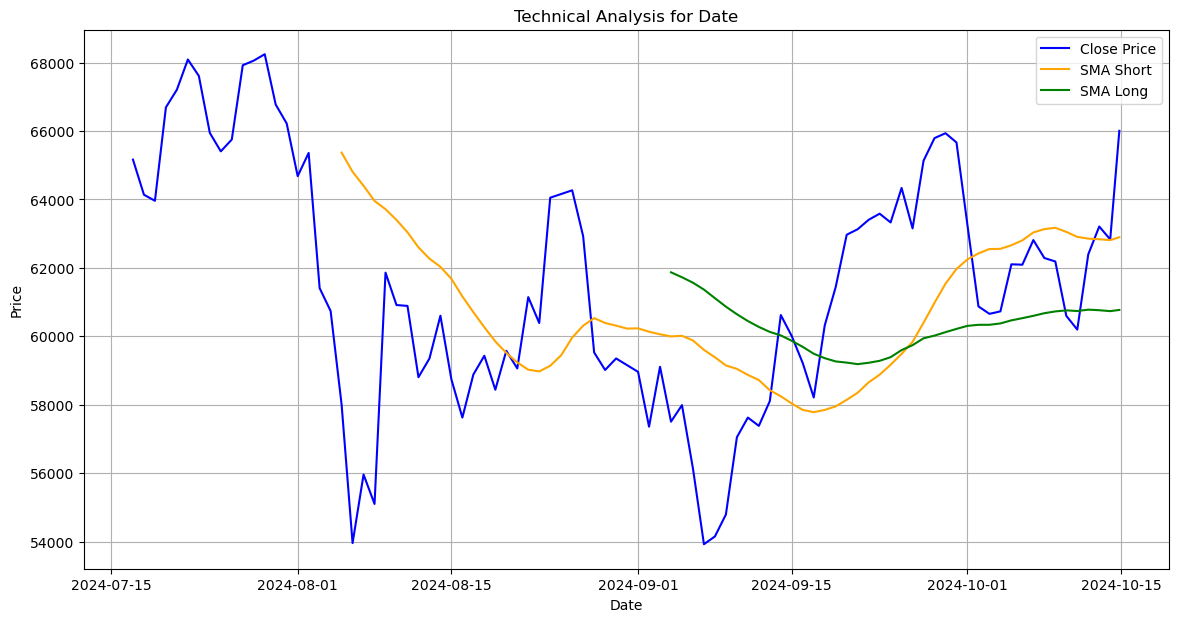

CoinGecko Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 20:02:27


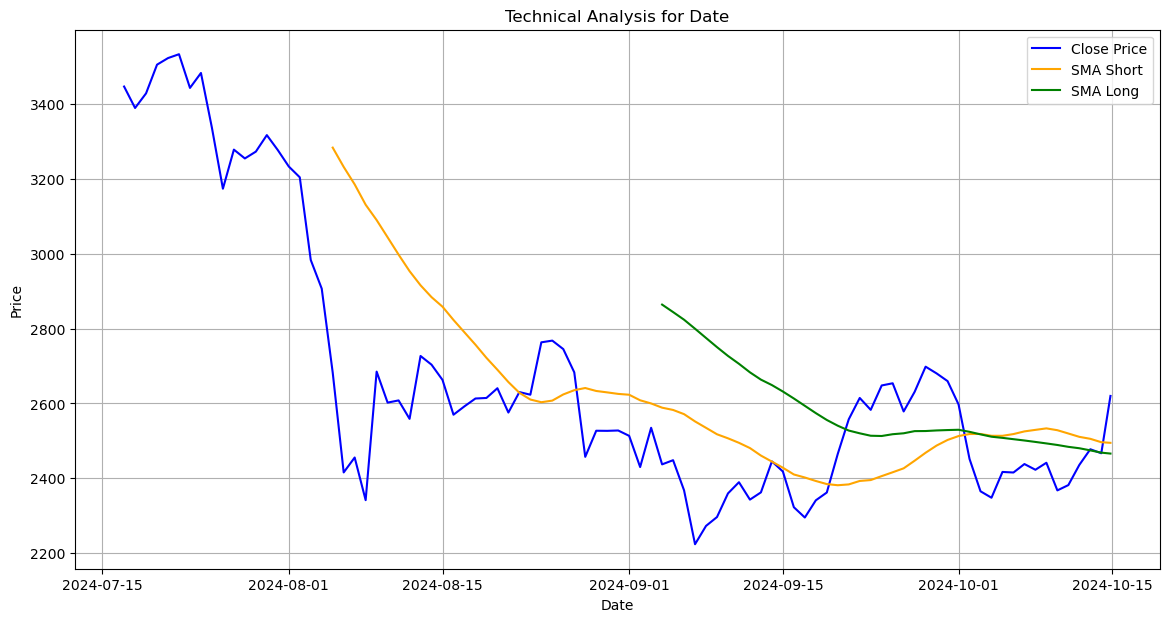

CoinGecko Data for litecoin: 2024-07-17 00:00:00 to 2024-10-14 20:05:37


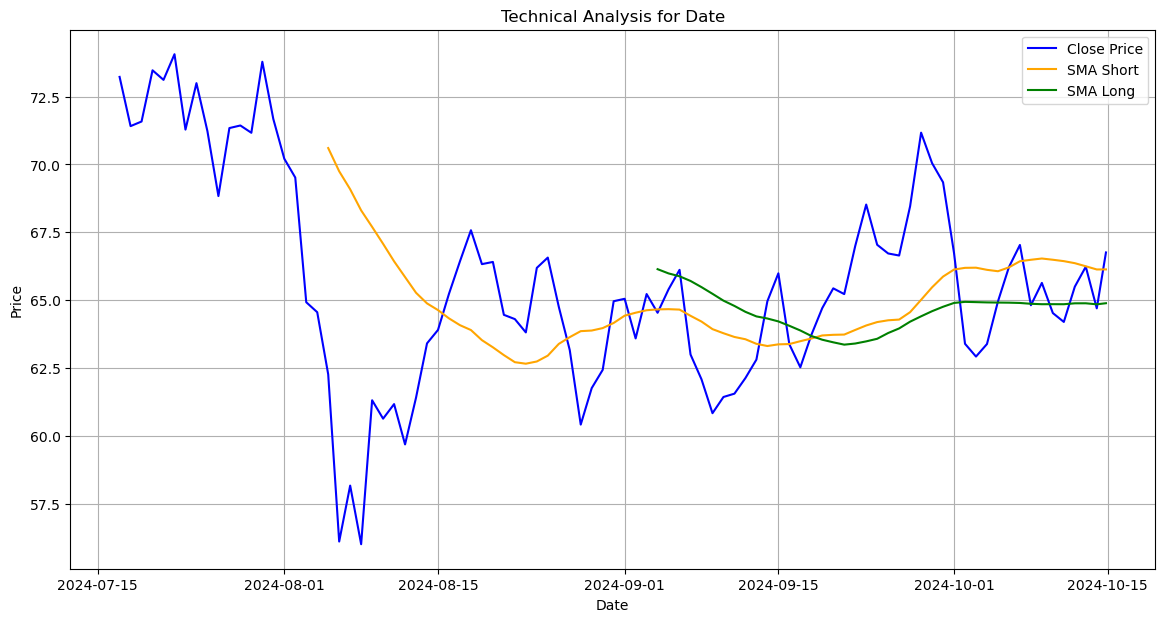


Fetching data for bitcoin...
CoinGecko Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 19:55:45
Error fetching data from Binance for BTCUSDT: 451 Client Error:  for url: https://api.binance.com/api/v3/klines?symbol=BTCUSDT&interval=1d&limit=90
Skipping bitcoin due to empty DataFrame from Binance
Fetched data for bitcoin: 91 records.

Fetching data for ethereum...
CoinGecko Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 20:02:27
Error fetching data from Binance for ETHUSDT: 451 Client Error:  for url: https://api.binance.com/api/v3/klines?symbol=ETHUSDT&interval=1d&limit=90
Skipping ethereum due to empty DataFrame from Binance
Fetched data for ethereum: 91 records.

Fetching data for litecoin...
CoinGecko API error for litecoin: 429 Client Error: Too Many Requests for url: https://api.coingecko.com/api/v3/coins/litecoin/market_chart?vs_currency=usd&days=90&interval=daily
Error fetching data from Binance for LTCUSDT: 451 Client Error:  for url: https://api.binance.com/api/v3/k

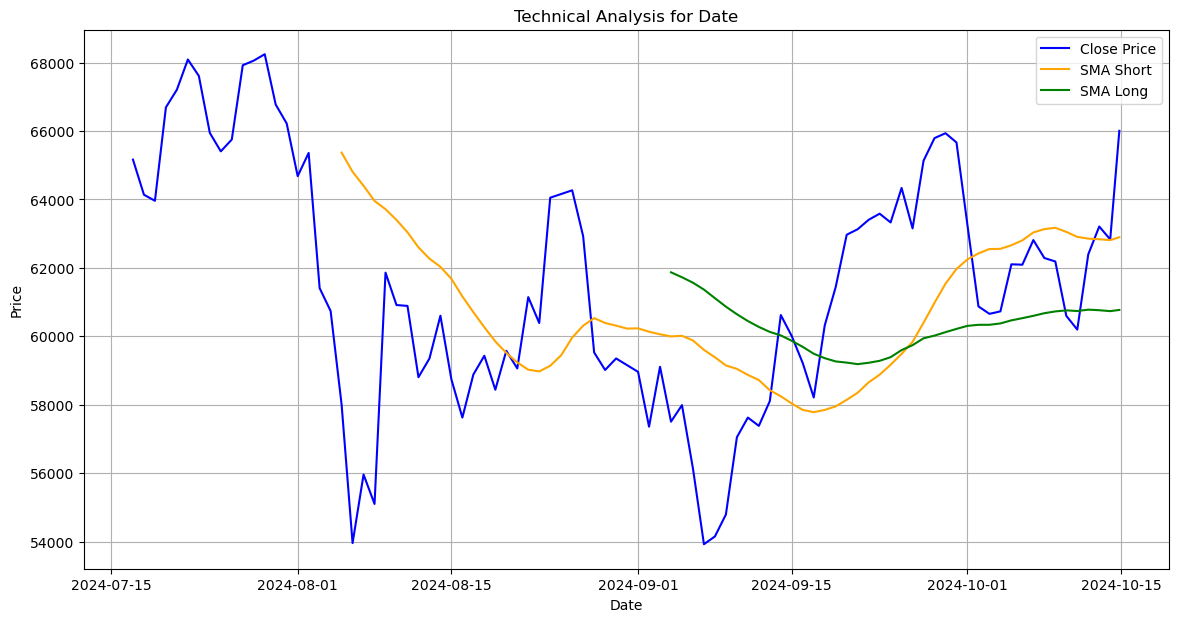


Technical analysis for bitcoin:
                   Close  SMA_Short  SMA_Long  RSI    Trend RSI_Status
Date                                                                  
2024-07-17  65162.236252        NaN       NaN  NaN  Neutral    Neutral
2024-07-18  64136.313844        NaN       NaN  NaN  Neutral    Neutral
2024-07-19  63959.569008        NaN       NaN  NaN  Neutral    Neutral
2024-07-20  66689.548807        NaN       NaN  NaN  Neutral    Neutral
2024-07-21  67206.064706        NaN       NaN  NaN  Neutral    Neutral
Data for bitcoin saved to bitcoin_Crypto_analysis.csv


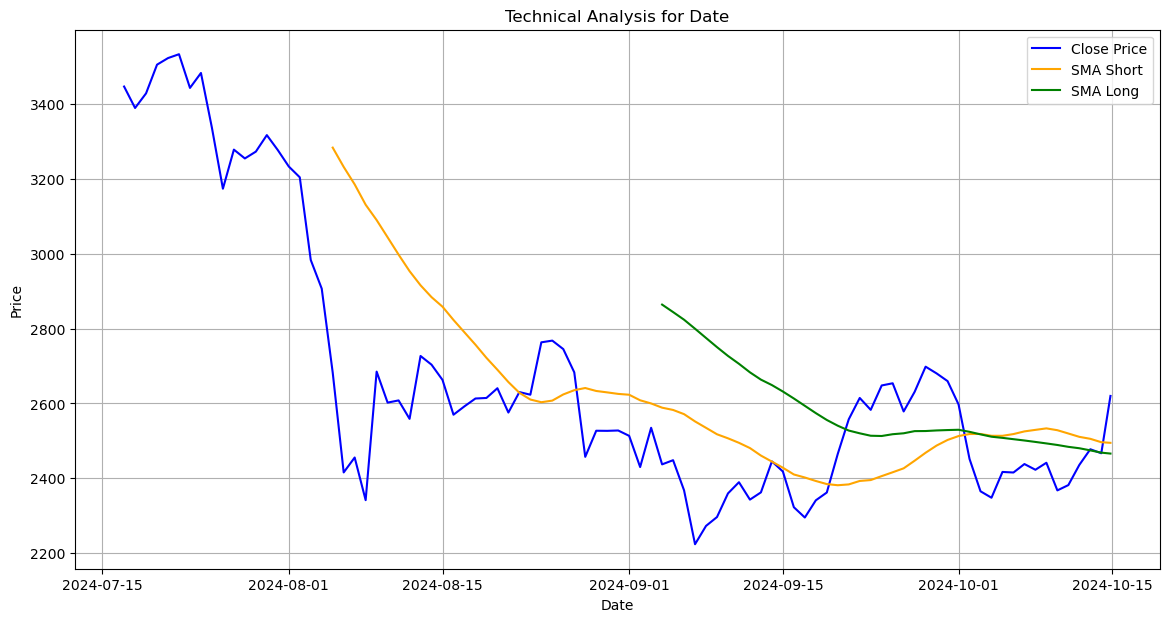


Technical analysis for ethereum:
                  Close  SMA_Short  SMA_Long  RSI    Trend RSI_Status
Date                                                                 
2024-07-17  3446.765889        NaN       NaN  NaN  Neutral    Neutral
2024-07-18  3389.441287        NaN       NaN  NaN  Neutral    Neutral
2024-07-19  3428.552019        NaN       NaN  NaN  Neutral    Neutral
2024-07-20  3505.222536        NaN       NaN  NaN  Neutral    Neutral
2024-07-21  3522.801303        NaN       NaN  NaN  Neutral    Neutral
Data for ethereum saved to ethereum_Crypto_analysis.csv
No data available for litecoin. Skipping analysis.


In [71]:
import hashlib
import requests
import pandas as pd
import matplotlib.pyplot as plt
from ta import momentum
from datetime import datetime, timedelta, timezone

# =========================
# Configuration and Settings
# =========================
# List of cryptocurrencies to analyze (CoinGecko IDs)
CRYPTOCURRENCIES = ['bitcoin', 'ethereum', 'litecoin']

# Timeframe for historical data (Last 90 days)
DAYS = 90  # Using integer for clarity

# Technical indicators settings
SMA_SHORT = 20  # Short-term Simple Moving Average
SMA_LONG = 50   # Long-term Simple Moving Average
RSI_PERIOD = 14

# API Keys (Replace with your actual API keys)
API_KEYS = {
    'cryptocompare': 'CRYPTOCOMPARE_API_KEY',
    'coinapi': 'COINAPI_API_KEY',
    'messari': 'MESSARI_API_KEY',
    'nomics': 'NOMICS_API_KEY',
    # Add other API keys as needed
}

# =========================
# Utility Functions
# =========================
def get_hash(data):
    """Generates a SHA-256 hash for the given data."""
    hash_object = hashlib.sha256(data.encode())
    return hash_object.hexdigest()

# =========================
# Data Fetching Functions
# =========================
def fetch_coin_gecko_data(crypto_id, vs_currency='usd', days=DAYS):
    """Fetches historical market data for a cryptocurrency from CoinGecko."""
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        prices['Date'] = pd.to_datetime(prices['timestamp'], unit='ms')
        prices.set_index('Date', inplace=True)
        prices['Close'] = prices['price'].astype(float)  # Ensure float type
        prices = prices[['Close']].sort_index()
        
        # Verification
        print(f"CoinGecko Data for {crypto_id}: {prices.index.min()} to {prices.index.max()}")
        
        prices['Hash'] = prices['Close'].apply(lambda x: get_hash(str(x)))
        return prices
    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error for {crypto_id}: {e}")
        return pd.DataFrame()

# ... (keep other fetching functions unchanged)

# =========================
# Technical Analysis Functions
# =========================
def perform_technical_analysis(prices):
    """Perform technical analysis on the historical price data."""
    if prices.empty:
        return None
    
    # Calculate Technical Indicators
    prices['SMA_Short'] = prices['Close'].rolling(window=SMA_SHORT).mean()
    prices['SMA_Long'] = prices['Close'].rolling(window=SMA_LONG).mean()
    prices['RSI'] = momentum.RSIIndicator(prices['Close'], window=RSI_PERIOD).rsi()
    
    # Create a DataFrame to hold results
    analysis_results = prices[['Close', 'SMA_Short', 'SMA_Long', 'RSI']]
    
    # Plotting the technical indicators
    plt.figure(figsize=(14, 7))
    plt.plot(prices.index, prices['Close'], label='Close Price', color='blue')
    plt.plot(prices.index, prices['SMA_Short'], label='SMA Short', color='orange')
    plt.plot(prices.index, prices['SMA_Long'], label='SMA Long', color='green')
    plt.title(f'Technical Analysis for {prices.index.name or "Cryptocurrency"}')  # Changed to use index name or default text
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()
    
    return analysis_results

def identify_trends(df):
    """Identifies upward and downward trends based on technical indicators."""
    # Ensure we're modifying the DataFrame itself, not a copy
    df = df.copy()  # Create a deep copy to avoid SettingWithCopyWarning
    df.loc[:, 'Trend'] = 'Neutral'
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Trend'] = 'Uptrend'
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Trend'] = 'Downtrend'
    
    df.loc[:, 'RSI_Status'] = 'Neutral'
    df.loc[df['RSI'] > 70, 'RSI_Status'] = 'Overbought'
    df.loc[df['RSI'] < 30, 'RSI_Status'] = 'Oversold'
    
    return df
    
# =========================
# Main Execution
# =========================
if __name__ == '__main__':
    for crypto in CRYPTOCURRENCIES:
        prices = fetch_coin_gecko_data(crypto)
        if not prices.empty:
            technical_analysis_results = perform_technical_analysis(prices)

# =========================
# Main Execution
# =========================
if __name__ == "__main__":
    # Fetch all cryptocurrency data
    all_crypto_data = fetch_all_crypto_data()

    # Perform technical analysis and trend identification
    for crypto, data in all_crypto_data.items():
        if data.empty:
            print(f"No data available for {crypto}. Skipping analysis.")
            continue

        # Perform technical analysis
        analyzed_data = perform_technical_analysis(data)
        
        # Identify trends
        trend_data = identify_trends(analyzed_data)

        # Print the results
        print(f"\nTechnical analysis for {crypto}:")
        print(trend_data.head())

        # Save to CSV
        csv_filename = f"{crypto}_Crypto_analysis.csv"
        trend_data.to_csv(csv_filename)
        print(f"Data for {crypto} saved to {csv_filename}")

CoinGecko Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 19:55:45
CoinGecko Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 20:02:27
CoinGecko Data for litecoin: 2024-07-17 00:00:00 to 2024-10-14 20:05:37


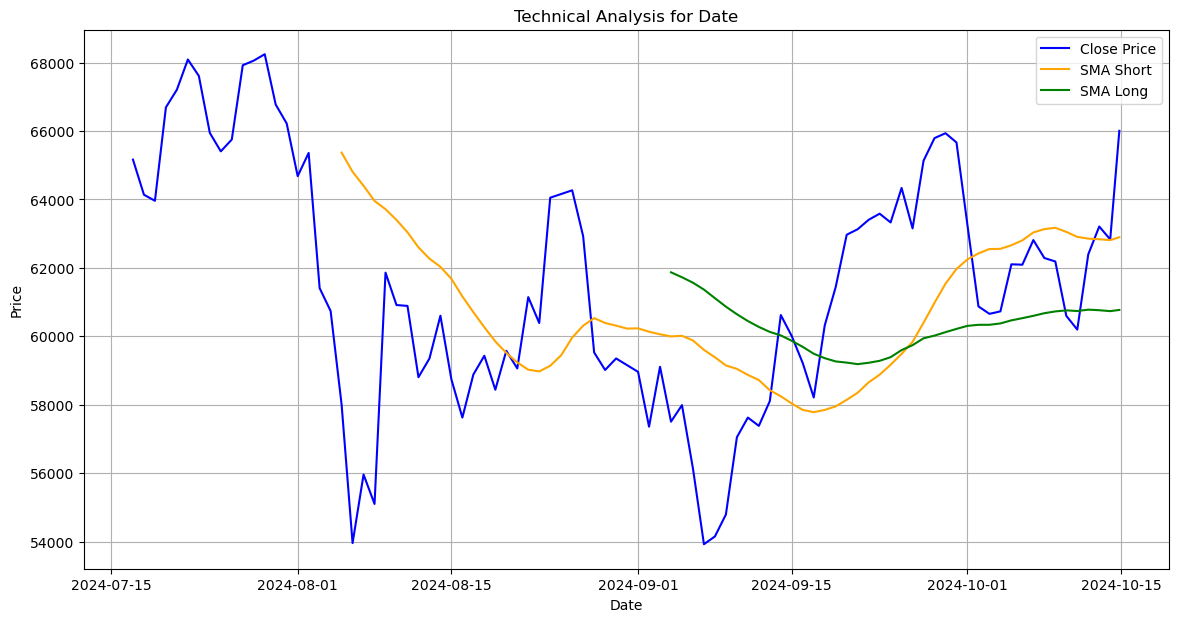


Technical analysis for bitcoin:
                   Close  SMA_Short  SMA_Long  RSI    Trend RSI_Status
Date                                                                  
2024-07-17  65162.236252        NaN       NaN  NaN  Neutral    Neutral
2024-07-18  64136.313844        NaN       NaN  NaN  Neutral    Neutral
2024-07-19  63959.569008        NaN       NaN  NaN  Neutral    Neutral
2024-07-20  66689.548807        NaN       NaN  NaN  Neutral    Neutral
2024-07-21  67206.064706        NaN       NaN  NaN  Neutral    Neutral
Data for bitcoin saved to bitcoin_Crypto_analysis.csv


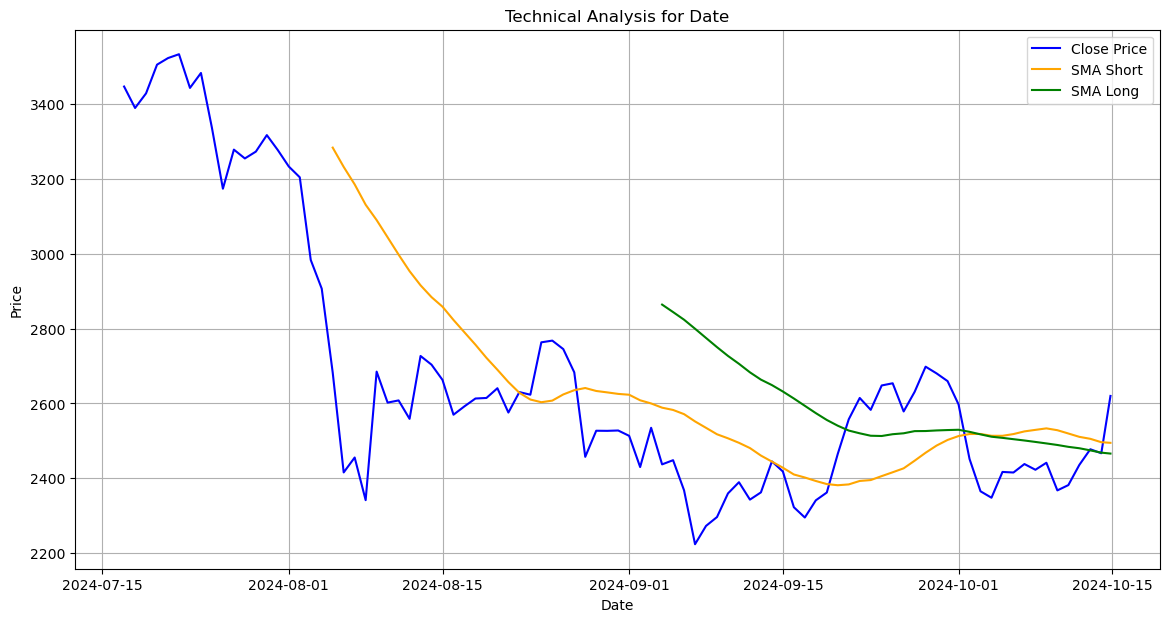


Technical analysis for ethereum:
                  Close  SMA_Short  SMA_Long  RSI    Trend RSI_Status
Date                                                                 
2024-07-17  3446.765889        NaN       NaN  NaN  Neutral    Neutral
2024-07-18  3389.441287        NaN       NaN  NaN  Neutral    Neutral
2024-07-19  3428.552019        NaN       NaN  NaN  Neutral    Neutral
2024-07-20  3505.222536        NaN       NaN  NaN  Neutral    Neutral
2024-07-21  3522.801303        NaN       NaN  NaN  Neutral    Neutral
Data for ethereum saved to ethereum_Crypto_analysis.csv


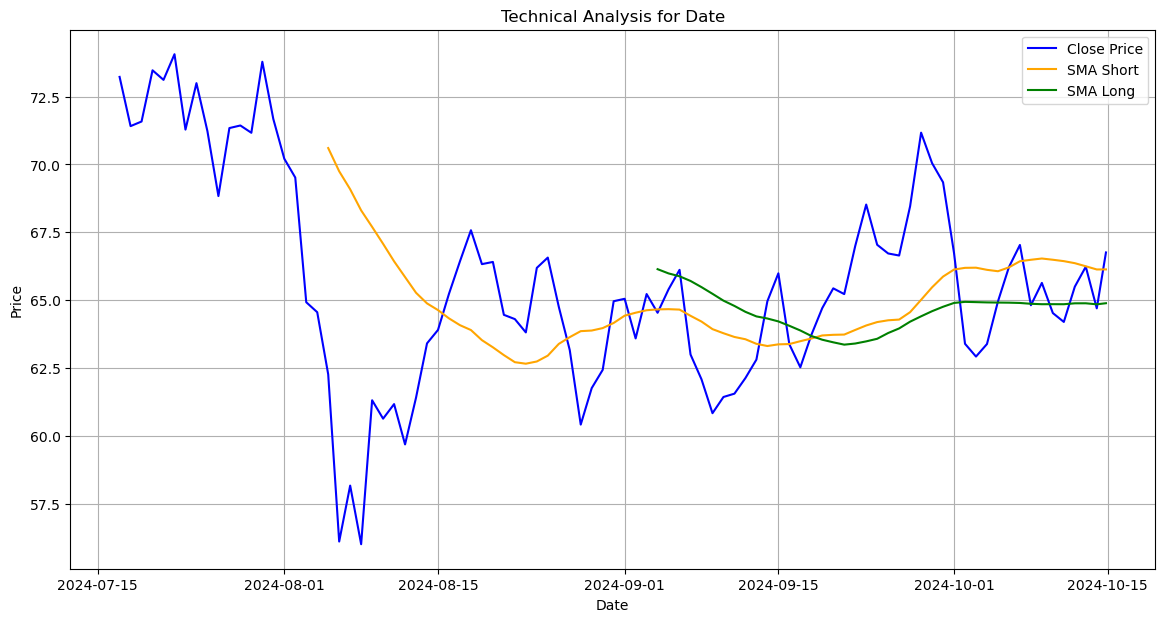


Technical analysis for litecoin:
                Close  SMA_Short  SMA_Long  RSI    Trend RSI_Status
Date                                                               
2024-07-17  73.222573        NaN       NaN  NaN  Neutral    Neutral
2024-07-18  71.410053        NaN       NaN  NaN  Neutral    Neutral
2024-07-19  71.579671        NaN       NaN  NaN  Neutral    Neutral
2024-07-20  73.465222        NaN       NaN  NaN  Neutral    Neutral
2024-07-21  73.112999        NaN       NaN  NaN  Neutral    Neutral
Data for litecoin saved to litecoin_Crypto_analysis.csv


In [69]:
import hashlib
import requests
import pandas as pd
import matplotlib.pyplot as plt
from ta import momentum
from datetime import datetime, timedelta, timezone

# =========================
# Configuration and Settings
# =========================
# List of cryptocurrencies to analyze (CoinGecko IDs)
CRYPTOCURRENCIES = ['bitcoin', 'ethereum', 'litecoin']

# Timeframe for historical data (Last 90 days)
DAYS = 90  # Using integer for clarity

# Technical indicators settings
SMA_SHORT = 20  # Short-term Simple Moving Average
SMA_LONG = 50   # Long-term Simple Moving Average
RSI_PERIOD = 14

# API Keys (Replace with your actual API keys)
API_KEYS = {
    'cryptocompare': 'CRYPTOCOMPARE_API_KEY',
    'coinapi': 'COINAPI_API_KEY',
    'messari': 'MESSARI_API_KEY',
    'nomics': 'NOMICS_API_KEY',
    # Add other API keys as needed
}

# =========================
# Utility Functions
# =========================
def get_hash(data):
    """Generates a SHA-256 hash for the given data."""
    hash_object = hashlib.sha256(data.encode())
    return hash_object.hexdigest()

# =========================
# Data Fetching Functions
# =========================
def fetch_coin_gecko_data(crypto_id, vs_currency='usd', days=DAYS):
    """Fetches historical market data for a cryptocurrency from CoinGecko."""
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        prices['Date'] = pd.to_datetime(prices['timestamp'], unit='ms')
        prices.set_index('Date', inplace=True)
        prices['Close'] = prices['price'].astype(float)  # Ensure float type
        prices = prices[['Close']].sort_index()
        
        # Verification
        print(f"CoinGecko Data for {crypto_id}: {prices.index.min()} to {prices.index.max()}")
        
        prices['Hash'] = prices['Close'].apply(lambda x: get_hash(str(x)))
        return prices
    except requests.exceptions.RequestException as e:
        print(f"CoinGecko API error for {crypto_id}: {e}")
        return pd.DataFrame()

# =========================
# Technical Analysis Functions
# =========================
def perform_technical_analysis(prices):
    """Perform technical analysis on the historical price data."""
    if prices.empty:
        return None
    
    # Calculate Technical Indicators
    prices['SMA_Short'] = prices['Close'].rolling(window=SMA_SHORT).mean()
    prices['SMA_Long'] = prices['Close'].rolling(window=SMA_LONG).mean()
    prices['RSI'] = momentum.RSIIndicator(prices['Close'], window=RSI_PERIOD).rsi()
    
    # Create a DataFrame to hold results
    analysis_results = prices[['Close', 'SMA_Short', 'SMA_Long', 'RSI']]
    
    # Plotting the technical indicators
    plt.figure(figsize=(14, 7))
    plt.plot(prices.index, prices['Close'], label='Close Price', color='blue')
    plt.plot(prices.index, prices['SMA_Short'], label='SMA Short', color='orange')
    plt.plot(prices.index, prices['SMA_Long'], label='SMA Long', color='green')
    plt.title(f'Technical Analysis for {prices.index.name or "Cryptocurrency"}')  # Changed to use index name or default text
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()
    
    return analysis_results

# =========================
# Trend Identification Function
# =========================
def identify_trends(df):
    """Identifies upward and downward trends based on technical indicators."""
    # Ensure we're modifying the DataFrame itself, not a copy
    df.loc[:, 'Trend'] = 'Neutral'
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Trend'] = 'Uptrend'
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Trend'] = 'Downtrend'
    
    df.loc[:, 'RSI_Status'] = 'Neutral'
    df.loc[df['RSI'] > 70, 'RSI_Status'] = 'Overbought'
    df.loc[df['RSI'] < 30, 'RSI_Status'] = 'Oversold'
    
    return df

# =========================
# Main Execution
# =========================
if __name__ == "__main__":
    all_crypto_data = {}

    # Fetch historical data for each cryptocurrency
    for crypto in CRYPTOCURRENCIES:
        prices = fetch_coin_gecko_data(crypto)
        all_crypto_data[crypto] = prices

    # Perform technical analysis and trend identification
    for crypto, data in all_crypto_data.items():
        if data.empty:
            print(f"No data available for {crypto}. Skipping analysis.")
            continue

        # Perform technical analysis
        analyzed_data = perform_technical_analysis(data)
        
        if analyzed_data is not None:
            # Identify trends
            trend_data = identify_trends(analyzed_data)

            # Print the results
            print(f"\nTechnical analysis for {crypto}:")
            print(trend_data.head())

            # Save to CSV
            csv_filename = f"{crypto}_Crypto_analysis.csv"
            trend_data.to_csv(csv_filename)
            print(f"Data for {crypto} saved to {csv_filename}")


=== Fetching data for bitcoin ===
CoinGecko Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 18:24:45
Combined Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 18:24:45
Fetched data for bitcoin: 91 records.

=== Fetching data for ethereum ===
CoinGecko Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 18:31:02
Combined Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 18:31:02
Fetched data for ethereum: 91 records.

=== Fetching data for litecoin ===
CoinGecko Data for litecoin: 2024-07-17 00:00:00 to 2024-10-14 18:29:55
Combined Data for litecoin: 2024-07-17 00:00:00 to 2024-10-14 18:29:55
Fetched data for litecoin: 91 records.


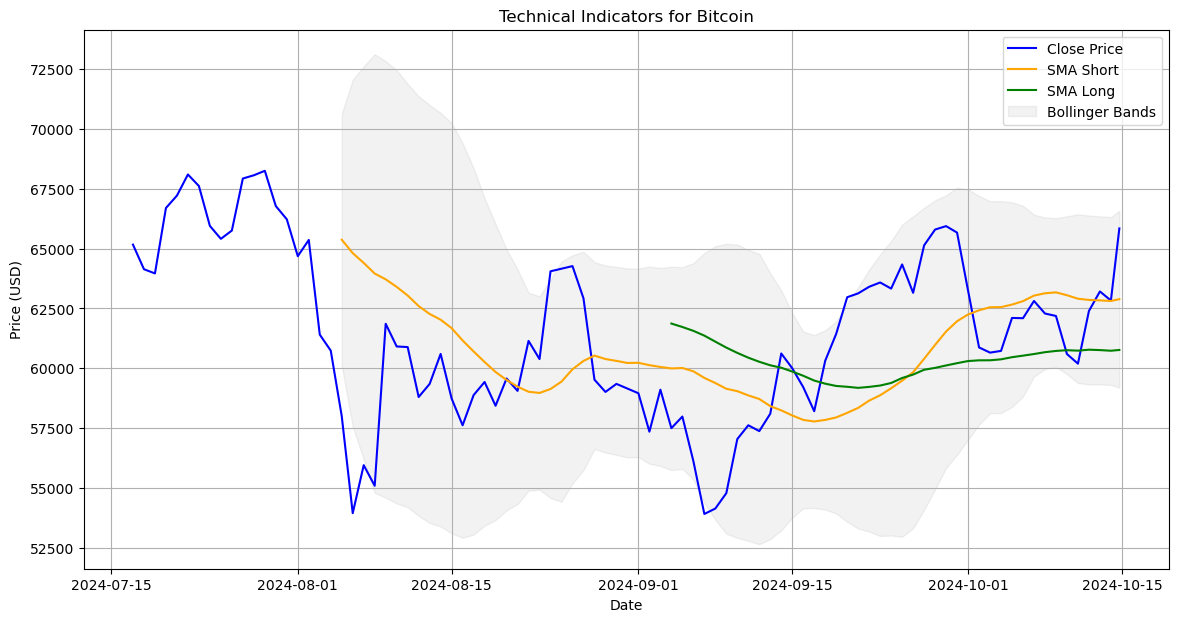

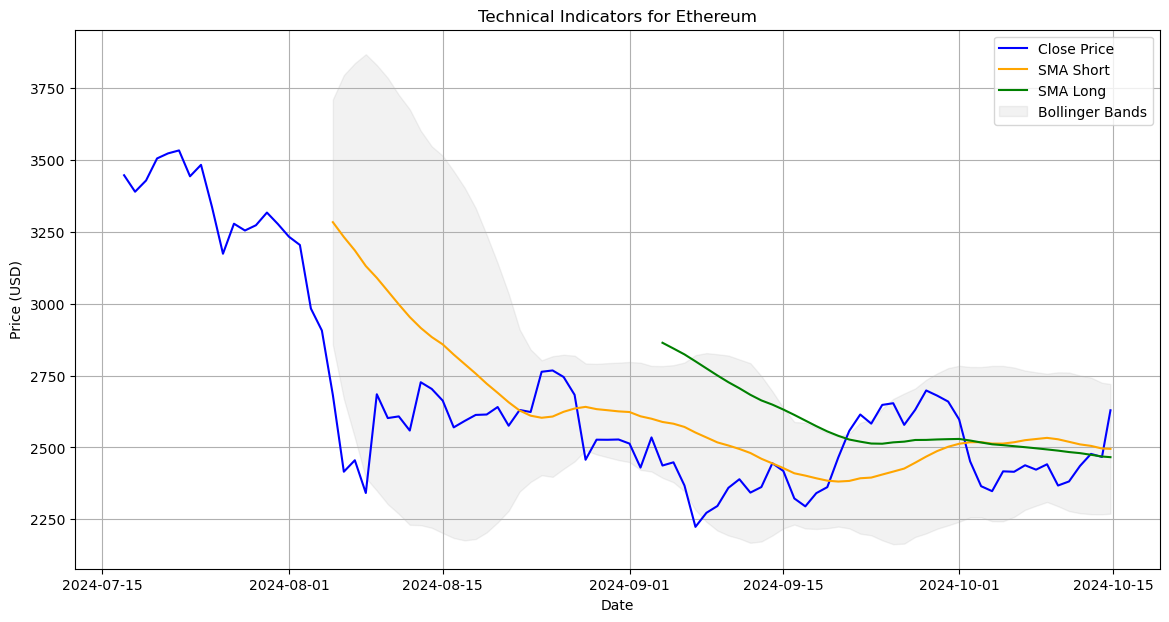

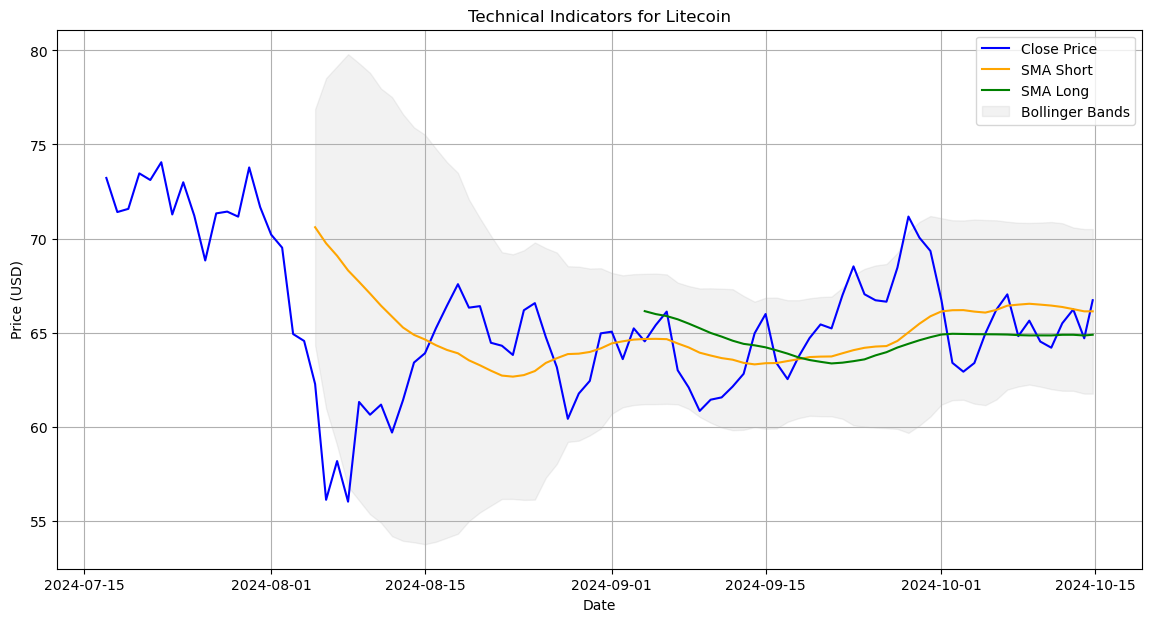


=== Fetching data for bitcoin ===
CoinGecko Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 18:24:45
Combined Data for bitcoin: 2024-07-17 00:00:00 to 2024-10-14 18:24:45
Fetched data for bitcoin: 91 records.

=== Fetching data for ethereum ===
CoinGecko Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 18:31:02
Combined Data for ethereum: 2024-07-17 00:00:00 to 2024-10-14 18:31:02
Fetched data for ethereum: 91 records.

=== Fetching data for litecoin ===
CoinGecko API error for litecoin: 429 Client Error: Too Many Requests for url: https://api.coingecko.com/api/v3/coins/litecoin/market_chart?vs_currency=usd&days=90&interval=daily
No data fetched for litecoin. Skipping.

Technical analysis for bitcoin:
                   Close                                            Data ID  \
Date                                                                          
2024-07-17  65162.236252  c213cfc0bc7e695ac7193d72f6b89357f9f75a88f57df7...   
2024-07-18  64136.313844  a7b85df8c71a2d9f3

In [58]:
import hashlib
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta import trend, momentum, volatility
from datetime import datetime, timedelta, timezone

# =========================
# Configuration and Settings
# =========================
# List of cryptocurrencies to analyze (CoinGecko IDs)
CRYPTOCURRENCIES = ['bitcoin', 'ethereum', 'litecoin']

# Fiat currencies for exchange rates
FIAT_CURRENCIES = ['USD', 'EUR', 'JPY', 'GBP', 'AUD']

# Timeframe for historical data (Last 90 days)
DAYS = '90'  # API may expect string

# Technical indicators settings
SMA_SHORT = 20  # Short-term Simple Moving Average
SMA_LONG = 50   # Long-term Simple Moving Average
RSI_PERIOD = 14

# API Keys (Replace with your actual API keys)
API_KEYS = {
    'cryptocompare': 'CRYPTOCOMPARE_API_KEY',
    'coinapi': 'COINAPI_API_KEY',
    'messari': 'MESSARI_API_KEY',
    'nomics': 'NOMICS_API_KEY',
    'exchangerate_api': 'EXCHANGERATE_API_KEY',
    # Add other API keys as needed
}

# =========================
# Utility Functions
# =========================
def get_hash(data):
    """Generates a SHA-256 hash for the given data."""
    hash_object = hashlib.sha256(data.encode())
    return hash_object.hexdigest()

# =========================
# Data Fetching Functions
# =========================

def fetch_coin_gecko_data(crypto_id, vs_currency='usd', days=DAYS):
    """Fetches historical market data for a cryptocurrency from CoinGecko."""
    url = f'https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart'
    params = {
        'vs_currency': vs_currency,
        'days': days,
        'interval': 'daily'
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        prices = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
        prices['Date'] = pd.to_datetime(prices['timestamp'], unit='ms')
        prices.set_index('Date', inplace=True)
        prices['Close'] = prices['price']
        prices = prices[['Close']].sort_index()
        
        # Verification
        print(f"CoinGecko Data for {crypto_id}: {prices.index.min()} to {prices.index.max()}")
        
        prices['Hash'] = prices['Close'].apply(lambda x: get_hash(str(x)))
        return prices
    except Exception as e:
        print(f"CoinGecko API error for {crypto_id}: {e}")
        return pd.DataFrame()

# Placeholder functions for the other data sources
def fetch_cryptocompare_data(symbol):
    """Placeholder for fetching data from CryptoCompare."""
    return pd.DataFrame()  # Implement actual API call

def fetch_coinapi_data(symbol):
    """Placeholder for fetching data from CoinAPI."""
    return pd.DataFrame()  # Implement actual API call

def fetch_messari_data(symbol):
    """Placeholder for fetching data from Messari."""
    return pd.DataFrame()  # Implement actual API call

def fetch_kraken_data(symbol):
    """Placeholder for fetching data from Kraken."""
    return pd.DataFrame()  # Implement actual API call

def fetch_nomics_data(symbol):
    """Placeholder for fetching data from Nomics."""
    return pd.DataFrame()  # Implement actual API call

def fetch_binance_data(symbol):
    """Placeholder for fetching data from Binance."""
    return pd.DataFrame()  # Implement actual API call

def perform_technical_analysis(df):
    """Applies technical indicators to the DataFrame using the `ta` library."""
    df['Close'] = df['Close'].astype(float)  # Ensure 'Close' is in float
    df.dropna(subset=['Close'], inplace=True)  # Drop NaN values if necessary
    df['SMA_Short'] = trend.sma_indicator(close=df['Close'], window=SMA_SHORT)
    df['SMA_Long'] = trend.sma_indicator(close=df['Close'], window=SMA_LONG)
    df['RSI'] = momentum.rsi(close=df['Close'], window=RSI_PERIOD)

    # Corrected BollingerBands usage
    bollinger = volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()
    
    return df

def identify_trends(df):
    """Identifies upward and downward trends based on technical indicators."""
    df['Trend'] = 'Neutral'
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Trend'] = 'Uptrend'
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Trend'] = 'Downtrend'
    df['RSI_Status'] = 'Neutral'
    df.loc[df['RSI'] > 70, 'RSI_Status'] = 'Overbought'
    df.loc[df['RSI'] < 30, 'RSI_Status'] = 'Oversold'
    return df

def plot_technical_indicators(df, crypto):
    plt.figure(figsize=(14,7))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue')
    plt.plot(df.index, df['SMA_Short'], label='SMA Short', color='orange')
    plt.plot(df.index, df['SMA_Long'], label='SMA Long', color='green')
    plt.fill_between(df.index, df['Bollinger_Low'], df['Bollinger_High'], color='grey', alpha=0.1, label='Bollinger Bands')
    plt.title(f"Technical Indicators for {crypto.capitalize()}")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid()
    plt.show()

# =========================
# Data Fetching
# =========================

def fetch_all_crypto_data():
    """Fetches historical data from multiple sources for all cryptocurrencies."""
    crypto_data = {}
    for crypto in CRYPTOCURRENCIES:
        print(f"\n=== Fetching data for {crypto} ===")
        data_frames = []
        
        # 1. CoinGecko
        cg_data = fetch_coin_gecko_data(crypto)
        if not cg_data.empty:
            data_frames.append(cg_data)
        
        # 2. CryptoCompare
        cc_symbol = crypto_symbol_mapping(crypto, api='cryptocompare')
        cc_data = fetch_cryptocompare_data(cc_symbol)
        if not cc_data.empty:
            data_frames.append(cc_data)
        
        # 3. CoinAPI
        ca_symbol = crypto_symbol_mapping(crypto, api='coinapi')
        ca_data = fetch_coinapi_data(ca_symbol)
        if not ca_data.empty:
            data_frames.append(ca_data)
        
        # 4. Messari
        messari_id = crypto_symbol_mapping(crypto, api='messari')
        ms_data = fetch_messari_data(messari_id)
        if not ms_data.empty:
            data_frames.append(ms_data)
        
        # 5. Kraken
        kr_symbol = crypto_symbol_mapping(crypto, api='kraken')
        kr_data = fetch_kraken_data(kr_symbol)
        if not kr_data.empty:
            data_frames.append(kr_data)
        
        # 6. Nomics
        nm_symbol = crypto_symbol_mapping(crypto, api='nomics')
        nm_data = fetch_nomics_data(nm_symbol)
        if not nm_data.empty:
            data_frames.append(nm_data)
        
        # 7. Binance
        bn_symbol = crypto_symbol_mapping(crypto, api='binance')
        bn_data = fetch_binance_data(symbol=bn_symbol)
        if not bn_data.empty:
            data_frames.append(bn_data)
        
        if not data_frames:
            print(f"No data fetched for {crypto}. Skipping.")
            continue
        
        # Combine all data frames on Date index
        combined = pd.concat(data_frames, axis=1)
        
        # Calculate mean Close price across available sources
        combined['Close'] = combined.filter(like='Close').mean(axis=1)
        combined = combined[['Close']].sort_index()
        
        # Verification of date range
        print(f"Combined Data for {crypto}: {combined.index.min()} to {combined.index.max()}")
        
        # Assign Data ID
        combined['Data ID'] = combined.index.to_series().apply(lambda x: get_hash(x.strftime('%Y-%m-%d')))
        
        # Store in crypto_data dictionary
        crypto_data[crypto] = combined
        print(f"Fetched data for {crypto}: {combined.shape[0]} records.")
    
    return crypto_data

def plot_rsi(df, crypto):
    plt.figure(figsize=(14, 5))
    plt.plot(df.index, df['RSI'], label='RSI', color='purple')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')
    plt.title(f'RSI for {crypto.capitalize()}')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid()
    plt.show()

def plot_buy_sell_signals(df, crypto):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.5)
    plt.plot(df.index, df['SMA_Short'], label='SMA Short', color='orange')
    plt.plot(df.index, df['SMA_Long'], label='SMA Long', color='green')

    # Buy signals
    buy_signals = df[df['Trend'] == 'Uptrend']
    plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='g', label='Buy Signal')

    # Sell signals
    sell_signals = df[df['Trend'] == 'Downtrend']
    plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='r', label='Sell Signal')

    plt.title(f'Buy/Sell Signals for {crypto.capitalize()}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

def plot_price_distribution(df, crypto):
    plt.figure(figsize=(10, 6))
    plt.hist(df['Close'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'Price Distribution for {crypto.capitalize()}')
    plt.xlabel('Price (USD)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

import seaborn as sns

def plot_correlation_heatmap(crypto_data):
    combined_df = pd.concat(crypto_data.values(), axis=1, keys=crypto_data.keys())
    close_prices = combined_df.xs('Close', axis=1, level=1)

    correlation = close_prices.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title('Correlation Heatmap of Closing Prices')
    plt.show()
    
# Example call to fetch and process data
# Uncomment to use
crypto_data = fetch_all_crypto_data()

# Perform analysis on each fetched crypto DataFrame
for crypto, df in crypto_data.items():
    if not df.empty:
        df = perform_technical_analysis(df)
        df = identify_trends(df)
        plot_technical_indicators(df, crypto)  # Replace 'bitcoin' with desired crypto
# =========================
# Main Execution
# =========================
if __name__ == "__main__":
    # Fetch all cryptocurrency data
    all_crypto_data = fetch_all_crypto_data()

    # Perform technical analysis and trend identification
    for crypto, data in all_crypto_data.items():
        if data.empty:
            print(f"No data available for {crypto}. Skipping analysis.")
            continue

        # Perform technical analysis
        analyzed_data = perform_technical_analysis(data)
        
        # Identify trends
        trend_data = identify_trends(analyzed_data)

        # Print the results
        print(f"\nTechnical analysis for {crypto}:")
        print(trend_data.head())

        # Save to CSV
        csv_filename = f"{crypto}_technical_analysis.csv"
        trend_data.to_csv(csv_filename)
        print(f"Data for {crypto} saved to {csv_filename}")